## Import package

In [1]:
import warnings
warnings.filterwarnings("ignore")
    
import numpy as np
import pandas as pd
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from imblearn.over_sampling import ADASYN, SMOTE
from sklearn.feature_selection import chi2

## Load dataset: Train

In [2]:
import os
os.listdir("../../../")

['scala', 'resources', 'python']

In [3]:
train = pd.read_csv("../../../../../data/train/train.csv")
test = pd.read_csv("../../../../../data/test/test.csv")

In [4]:
print(train.shape)
print(test.shape)

(9557, 143)
(23856, 142)


In [5]:
train.head(5)

,Id,v2a1,hacdor,rooms,hacapo,v14a,refrig,v18q,v18q1,r4h1,...,SQBescolari,SQBage,SQBhogar_total,SQBedjefe,SQBhogar_nin,SQBovercrowding,SQBdependency,SQBmeaned,agesq,Target
0,ID_279628684,190000.0,0,3,0,1,1,0,NaN,0,...,100,1849,1,100,0,1.000000,0.0,100.0,1849,4
1,ID_f29eb3ddd,135000.0,0,4,0,1,1,1,1.0,0,...,144,4489,1,144,0,1.000000,64.0,144.0,4489,4
2,ID_68de51c94,NaN,0,8,0,1,1,0,NaN,0,...,121,8464,1,0,0,0.250000,64.0,121.0,8464,4
3,ID_d671db89c,180000.0,0,5,0,1,1,1,1.0,0,...,81,289,16,121,4,1.777778,1.0,121.0,289,4
4,ID_d56d6f5f5,180000.0,0,5,0,1,1,1,1.0,0,...,121,1369,16,121,4,1.777778,1.0,121.0,1369,4


In [6]:
test.head(5)

,Id,v2a1,hacdor,rooms,hacapo,v14a,refrig,v18q,v18q1,r4h1,...,age,SQBescolari,SQBage,SQBhogar_total,SQBedjefe,SQBhogar_nin,SQBovercrowding,SQBdependency,SQBmeaned,agesq
0,ID_2f6873615,NaN,0,5,0,1,1,0,NaN,1,...,4,0,16,9,0,1,2.25,0.25,272.25,16
1,ID_1c78846d2,NaN,0,5,0,1,1,0,NaN,1,...,41,256,1681,9,0,1,2.25,0.25,272.25,1681
2,ID_e5442cf6a,NaN,0,5,0,1,1,0,NaN,1,...,41,289,1681,9,0,1,2.25,0.25,272.25,1681
3,ID_a8db26a79,NaN,0,14,0,1,1,1,1.0,0,...,59,256,3481,1,256,0,1.00,0.00,256.00,3481
4,ID_a62966799,175000.0,0,4,0,1,1,1,1.0,0,...,18,121,324,1,0,1,0.25,64.00,NaN,324


In [7]:
f = open("../../../resources/continuousFeatures", "r")
continuous_columns = f.read().split(",")
f.close()

f = open("../../../resources/categoricalFeatures", "r")
categorical_columns = f.read().split(",")
f.close()

print("Number of numerical columns: {0}".format(len(continuous_columns)))
print("Number of categorical columns: {0}".format(len(categorical_columns)))

Number of numerical columns: 38
Number of categorical columns: 102


In [8]:
category, category_ount = np.unique(train["Target"], return_counts=True)
print("(Category, Count): {0}".format(zip(category, category_ount)))

(Category, Count): [(1, 755), (2, 1597), (3, 1209), (4, 5996)]


## Fill Nan values

In [9]:
null_columns = train.isnull().any()

In [10]:
train.columns[train.isnull().any()].tolist() ## continuous variables

['v2a1', 'v18q1', 'rez_esc', 'meaneduc', 'SQBmeaned']

## Chi-Square selection

In [11]:
result_chi2 = chi2(train[categorical_columns], train["Target"])
p_val = result_chi2[1]
sum(p_val < 0.05)

new_categorical_columns = [categorical_columns[index] for index,test in enumerate((p_val < 0.05).tolist()) if test]

In [12]:
categorical_columns = new_categorical_columns

In [13]:
len(categorical_columns)

76

## Train - Validation split

In [14]:
X_train, X_validation, y_train, y_validation = train_test_split(train[categorical_columns], train["Target"], test_size=0.2, stratify=train["Target"])

In [15]:
print(X_train.shape, y_train.shape)
print(X_validation.shape, y_validation.shape)

((7645, 76), (7645,))
((1912, 76), (1912,))


In [16]:
category, category_count = np.unique(y_train, return_counts=True)
print("(Category, Count): {0}".format(zip(category, category_count)))
      
category, category_count = np.unique(y_validation, return_counts=True)
print("(Category, Count): {0}".format(zip(category, category_count)))     

(Category, Count): [(1, 604), (2, 1278), (3, 967), (4, 4796)]
(Category, Count): [(1, 151), (2, 319), (3, 242), (4, 1200)]


## SVC Classifier

In [17]:
def svc_prediction(n_degree, X_train, y_train, X_test):
    estimator = SVC(kernel="poly", degree=n_degree)
    model = estimator.fit(X_train, y_train)
    return model.predict(X_train), model.predict(X_test)

In [18]:
def all_score(y_true, y_prediction):
    accuracy = accuracy_score(y_true, y_prediction)
    precision = precision_score(y_true, y_prediction, average="macro")
    recall = recall_score(y_true, y_prediction, average="macro")
    f1 = f1_score(y_true, y_prediction, average="macro")
    return accuracy, precision, recall, f1

In [19]:
def print_score(accuracy, precision, recall, f1):
    print('Accuracy:', accuracy)
    print('Precision:', precision)
    print('Recall:', recall)
    print('F1:', f1)

## Classification: SVC Classifier

In [20]:
prediction_train, prediction_validation = svc_prediction(1, X_train, y_train, X_validation)

In [21]:
accuracy, precision, recall, f1 = all_score(y_validation, prediction_validation)
print_score(accuracy, precision, recall, f1)

('Accuracy:', 0.6276150627615062)
('Precision:', 0.15690376569037656)
('Recall:', 0.25)
('F1:', 0.1928020565552699)


In [22]:
confusion_mc = confusion_matrix(y_validation, prediction_validation)
print confusion_mc

[[   0    0    0  151]
 [   0    0    0  319]
 [   0    0    0  242]
 [   0    0    0 1200]]


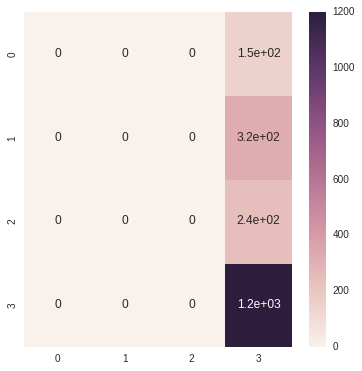

In [23]:
# convert to a dataframe
df_cm = pd.DataFrame(confusion_mc,
                     index = [i for i in range(0,4)],
                     columns = [i for i in range(0,4)])
# plot graph
plt.figure(figsize=(6,6)) # define graph
sns.heatmap(df_cm, annot=True) # draw heatmap, add annotation

In [24]:
unique_elements, counts_elements = np.unique(prediction_validation, return_counts=True)
print(unique_elements)
print(counts_elements)

[4]
[1912]


## Balanced datasets - ADASYN

In [25]:
ada = ADASYN()
X_ada, y_ada = ada.fit_sample(train[categorical_columns], train["Target"])

print(X_ada.shape, y_ada.shape)

X_ada_train, X_ada_validation, y_ada_train, y_ada_validation = train_test_split(X_ada, y_ada, test_size=0.2, stratify=y_ada)

prediction_ada_train, prediction_ada_validation = svc_prediction(1, X_ada_train, y_ada_train, X_ada_validation)

((23662, 76), (23662,))


/home/mahjoubi/anaconda2/lib/python2.7/json/encoder.py:207: DeprecationWarning: Interpreting naive datetime as local 2018-08-31 13:26:49.897076. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [26]:
accuracy, precision, recall, f1 = all_score(y_ada_validation, prediction_ada_validation)
print_score(accuracy, precision, recall, f1)

('Accuracy:', 0.3743925628565392)
('Precision:', 0.36058770344355984)
('Recall:', 0.3702302899489456)
('F1:', 0.3504368711806116)


/home/mahjoubi/anaconda2/lib/python2.7/json/encoder.py:207: DeprecationWarning: Interpreting naive datetime as local 2018-08-31 13:29:20.542275. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


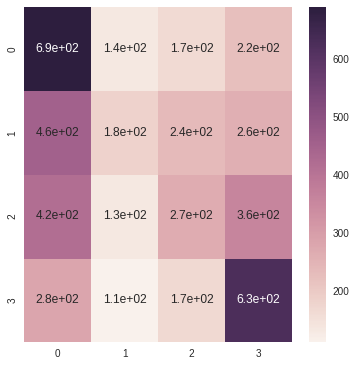

/home/mahjoubi/anaconda2/lib/python2.7/json/encoder.py:207: DeprecationWarning: Interpreting naive datetime as local 2018-08-31 13:29:20.555005. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [27]:
confusion_mc = confusion_matrix(y_ada_validation, prediction_ada_validation)
# print confusion_mc

# convert to a dataframe
df_cm = pd.DataFrame(confusion_mc,
                     index = [i for i in range(0,4)],
                     columns = [i for i in range(0,4)])
# plot graph
plt.figure(figsize=(6,6)) # define graph
sns.heatmap(df_cm, annot=True) # draw heatmap, add annotation

## Balanced datasets - SMOTE

In [28]:
smo = SMOTE(kind="svm")
X_resampled, y_resampled = smo.fit_sample(train[categorical_columns], train["Target"])

X_smo_train, X_smo_validation, y_smo_train, y_smo_validation = train_test_split(X_resampled, y_resampled, test_size=0.2, stratify=y_resampled)

prediction_smo_train, prediction_smo_validation = svc_prediction(2, X_smo_train, y_smo_train, X_smo_validation)

/home/mahjoubi/anaconda2/lib/python2.7/json/encoder.py:207: DeprecationWarning: Interpreting naive datetime as local 2018-08-31 13:29:32.498355. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [29]:
accuracy, precision, recall, f1 = all_score(y_smo_validation, prediction_smo_validation)
print_score(accuracy, precision, recall, f1)

('Accuracy:', 0.6001667708984783)
('Precision:', 0.6045033144665927)
('Recall:', 0.6001645468445928)
('F1:', 0.5998958458211681)


/home/mahjoubi/anaconda2/lib/python2.7/json/encoder.py:207: DeprecationWarning: Interpreting naive datetime as local 2018-08-31 13:33:04.578993. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


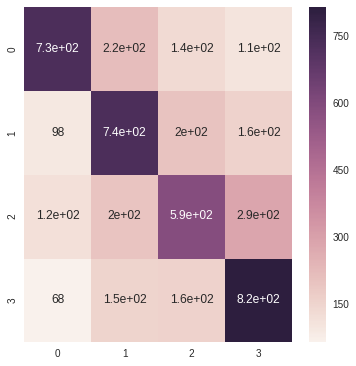

/home/mahjoubi/anaconda2/lib/python2.7/json/encoder.py:207: DeprecationWarning: Interpreting naive datetime as local 2018-08-31 13:33:11.146708. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [30]:
confusion_mc = confusion_matrix(y_smo_validation, prediction_smo_validation)
# print confusion_mc

# convert to a dataframe
df_cm = pd.DataFrame(confusion_mc,
                     index = [i for i in range(0,4)],
                     columns = [i for i in range(0,4)])
# plot graph
plt.figure(figsize=(6,6)) # define graph
sns.heatmap(df_cm, annot=True) # draw heatmap, add annotation

## Hyper-parameters tuning

In [31]:
n_degrees = range(1, 10)
accuracy_scores = {"train": [], "validation": []}
precision_scores = {"train": [], "validation": []}
recall_scores = {"train": [], "validation": []}
f1_scores = {"train": [], "validation": []}
print("Number of neighbor: "),
for n_degree in n_degrees:
    print(", {0}".format(n_degree)),
    prediction_smo_train, prediction_smo_validation = svc_prediction(n_degree, X_smo_train, y_smo_train, X_smo_validation)
    accuracy, precision, recall, f1 = all_score(y_smo_train, prediction_smo_train)
    accuracy_scores["train"].append(accuracy)
    precision_scores["train"].append(precision)
    recall_scores["train"].append(recall)
    f1_scores["train"].append(f1)  
    
    accuracy, precision, recall, f1 = all_score(y_smo_validation, prediction_smo_validation)
    accuracy_scores["validation"].append(accuracy)
    precision_scores["validation"].append(precision)
    recall_scores["validation"].append(recall)    
    f1_scores["validation"].append(f1)

Number of neighbor:  , 1 , 2 , 3 , 4 , 5 , 6 , 7 , 8 , 9


/home/mahjoubi/anaconda2/lib/python2.7/json/encoder.py:207: DeprecationWarning: Interpreting naive datetime as local 2018-08-31 13:33:36.474821. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [32]:
# estimator = SVC(kernel="rbf")
# model = estimator.fit(X_smo_train, y_smo_train)
# prediction_smo_train = model.predict(X_smo_train)
# prediction_smo_validation = model.predict(X_smo_validation)
# accuracy_rbf_train, precision_rbf_train, recall_rbf_train, f1_rbf_train = all_score(y_smo_train, prediction_smo_train)
# accuracy_rbf_test, precision_rbf_test, recall_rbf_test, f1_rbf_test = all_score(y_smo_validation, prediction_smo_validation)

# print_score(accuracy_rbf_train, precision_rbf_train, recall_rbf_train, f1_rbf_train)
# print("")
# print_score(accuracy_rbf_test, precision_rbf_test, recall_rbf_test, f1_rbf_test)

KeyboardInterrupt: 

/home/mahjoubi/anaconda2/lib/python2.7/json/encoder.py:207: DeprecationWarning: Interpreting naive datetime as local 2018-08-31 13:58:19.535551. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


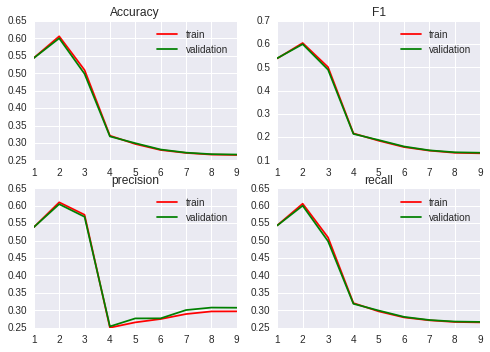

/home/mahjoubi/anaconda2/lib/python2.7/json/encoder.py:207: DeprecationWarning: Interpreting naive datetime as local 2018-08-31 14:00:33.414706. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [34]:
fig, ax = plt.subplots(nrows=2, ncols=2)

ax[0][0].plot(n_degrees, accuracy_scores["train"], c="r", label="train")
ax[0][0].plot(n_degrees, accuracy_scores["validation"], c="g", label="validation")
ax[0][0].set_title("Accuracy")
ax[0][0].legend()

ax[0][1].plot(n_degrees, f1_scores["train"], c="r", label="train")
ax[0][1].plot(n_degrees, f1_scores["validation"], c="g", label="validation")
ax[0][1].set_title("F1")
ax[0][1].legend()

ax[1][0].plot(n_degrees, precision_scores["train"], c="r", label="train")
ax[1][0].plot(n_degrees, precision_scores["validation"], c="g", label="validation")
ax[1][0].set_title("precision")
ax[1][0].legend()

ax[1][1].plot(n_degrees, recall_scores["train"], c="r", label="train")
ax[1][1].plot(n_degrees, recall_scores["validation"], c="g", label="validation")
ax[1][1].set_title("recall")
ax[1][1].legend()

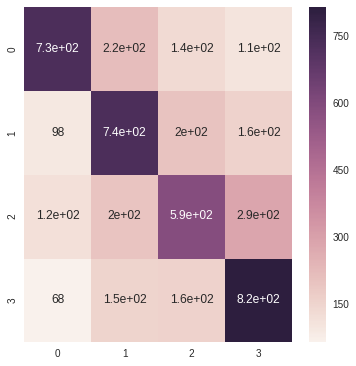

/home/mahjoubi/anaconda2/lib/python2.7/json/encoder.py:207: DeprecationWarning: Interpreting naive datetime as local 2018-08-31 14:01:36.954088. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [35]:
nearest_neighbors = SVC(degree=2)
model = nearest_neighbors.fit(X_smo_train, y_smo_train)
prediction_smo_validation = model.predict(X_smo_validation)


# print confusion_mc

# convert to a dataframe
df_cm = pd.DataFrame(confusion_mc,
                     index = [i for i in range(0,4)],
                     columns = [i for i in range(0,4)])
# plot graph
plt.figure(figsize=(6,6)) # define graph
sns.heatmap(df_cm, annot=True) # draw heatmap, add annotation

In [39]:
test[categorical_columns]

TypeError: 'bool' object has no attribute '__getitem__'

/home/mahjoubi/anaconda2/lib/python2.7/json/encoder.py:207: DeprecationWarning: Interpreting naive datetime as local 2018-08-31 14:04:01.657800. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [40]:
test = pd.read_csv("../../../../../data/test/test.csv")
prediction_kaggle = model.predict(test[categorical_columns])

/home/mahjoubi/anaconda2/lib/python2.7/json/encoder.py:207: DeprecationWarning: Interpreting naive datetime as local 2018-08-31 14:04:22.359242. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [41]:
unique_elements, counts_elements = np.unique(prediction_kaggle, return_counts=True)
print(unique_elements)
print(counts_elements)

[1 2 3 4]
[ 2586  4056  4402 12812]


/home/mahjoubi/anaconda2/lib/python2.7/json/encoder.py:207: DeprecationWarning: Interpreting naive datetime as local 2018-08-31 14:05:59.190595. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [42]:
id_kaggle = test["Id"]

/home/mahjoubi/anaconda2/lib/python2.7/json/encoder.py:207: DeprecationWarning: Interpreting naive datetime as local 2018-08-31 14:06:00.135178. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [43]:
d = {"Id": id_kaggle, "Target": prediction_kaggle}
data = pd.DataFrame(d)

/home/mahjoubi/anaconda2/lib/python2.7/json/encoder.py:207: DeprecationWarning: Interpreting naive datetime as local 2018-08-31 14:06:00.877744. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [44]:
data.head(5)

,Id,Target
0,ID_2f6873615,4
1,ID_1c78846d2,4
2,ID_e5442cf6a,4
3,ID_a8db26a79,4
4,ID_a62966799,4


/home/mahjoubi/anaconda2/lib/python2.7/json/encoder.py:207: DeprecationWarning: Interpreting naive datetime as local 2018-08-31 14:06:02.263393. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [45]:
data.to_csv("/home/mahjoubi/Documents/github/costa_rican_household_poverty/submission/sklearn/smote/svc.csv", index=False)

/home/mahjoubi/anaconda2/lib/python2.7/json/encoder.py:207: DeprecationWarning: Interpreting naive datetime as local 2018-08-31 14:06:05.904902. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [ ]:
estimator = SVC(kernel="rbf")
model = estimator.fit(X_smo_train, y_smo_train)
prediction_test = model.predict(test[categorical_columns])

d = {"Id": id_kaggle, "Target": prediction_test}
data = pd.DataFrame(d)
data.to_csv("/home/mahjoubi/Documents/github/costa_rican_household_poverty/submission/sklearn/smote/svc.csv", index=False)